In [105]:
###Import
import sys

#import geobayes_simple as gs
from matplotlib import pyplot as plt
from IPython.core.display import Image

%matplotlib inline
import pymc as pm
from pymc.Matplot import plot
import numpy as np
from IPython.core.pylabtools import figsize
figsize(10, 3)
import seaborn
seaborn.set_context(font_scale=2)
seaborn.set_style("white")

from pymc import graph

import scipy.optimize as sop
import scipy.stats as stats
import matplotlib.mlab as mlab

# CHAPTER I: A one-dimensional reservoir case

An abstract one-dimensional case of a petroleum reservoir is presented in this chapter. The underlying model and basic approach are inherited from De la Varga (2016). Parameters were adapted to better represent a reasonable geological petroleum system consisting of a reservoir with overlying seal in the subsurface. This way, a certain economic significance is ascribed to the model and further relevant questions can be derived. Regarding the petroleum sector, the problem of interest is most commonly one of estimating the monetary value contained in an oil or gas reservoir. Limiting the model to only one dimension and a small number of uncertain parameters allows for a relatively straightforward and simplified approach to assessing an abstract type of value for a reservoir and designing a respective loss function for value estimation. A step by step derivation of such as case follows below.

## 1 Constructing the one-dimensional model

De la Varga (2016) constructed a simple geological model using three uncertain locations in one-dimensional space, which mark the boundaries of layers. The probability of positions of these points are defined by sampling from normal distributions. Standard deviations of these distributions increase with depth, representing an increase in uncertainty. For an approximate represetantion of a petroleum system, the distribution means were set to depths of 2000 (seal top), 2050 (reservoir top) and 2200 (reservoir bottom). These points confine two layers in the middle, from which the upper one can be labeled as seal and the lower one as reservoir. The resulting model with its possible layer boundary locations is illustrated in Figure 1.

In [106]:
###Distributions for boundary locations
alpha = pm.Normal("alpha", -2000, 1./np.square(7.))
beta = pm.Normal("beta", -2050, 1./np.square(25))
gamma = pm.Normal("gamma", -2200, 1./np.square(45))

###Model
model = pm.Model([alpha, beta, gamma])

In [107]:
###PyMC simulation
M = pm.MCMC(model)
M.sample(iter=5000)

 [-----------------100%-----------------] 5000 of 5000 complete in 0.6 sec

In [108]:
alpha_samples = M.trace('alpha')[:]
beta_samples = M.trace('beta')[:]
gamma_samples = M.trace('gamma')[:]

alpha_samples, alpha_samples_all = M.trace('alpha')[-80:], M.trace("alpha")[:]
beta_samples, beta_samples_all = M.trace('beta')[-80:], M.trace("beta")[:]
gamma_samples, gamma_samples_all = M.trace('gamma')[-80:], M.trace('gamma')[:]

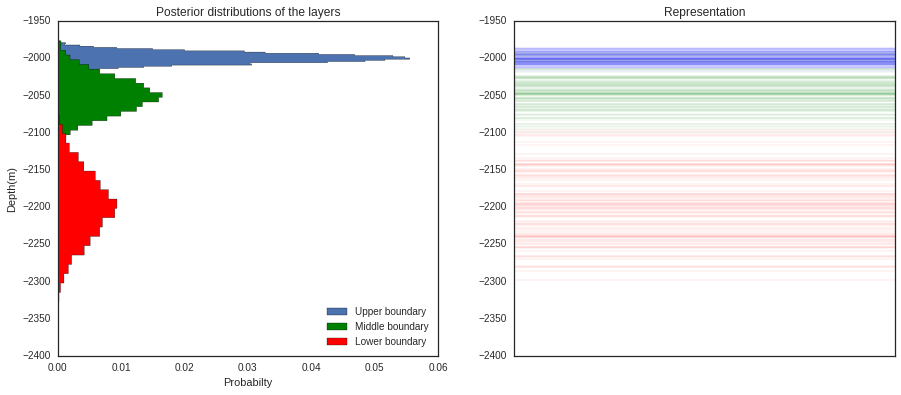

In [109]:
figsize(15,6)
fig, ax = plt.subplots(1, 2)

ax[0].hist(alpha_samples_all, histtype='stepfilled', bins=30, alpha=1,
    label="Upper boundary", normed=True,  orientation="horizontal")
ax[0].hist(beta_samples_all, histtype='stepfilled', bins=30, alpha=1,
    label="Middle boundary", normed=True, color = "g",  orientation="horizontal")
ax[0].hist(gamma_samples_all, histtype='stepfilled', bins=30, alpha=1,
 label="Lower boundary", normed=True, color = "r", orientation="horizontal")

ax[0].legend(loc = 0)
ax[0].set_title(r"""Posterior distributions of the layers""")
ax[0].set_ylabel("Depth(m)")
ax[0].set_ylim([-2400,-1950])
ax[0].set_xlabel("Probabilty")

ax[1].set_title("Representation")
ax[1].set_ylim([-2400,-1950])
ax[1].xaxis.set_visible(False)
for i in range(100):
    ax[1].axhline(alpha_samples_all[i], alpha = 0.05)
    ax[1].axhline(beta_samples_all[i], c = "g", alpha = 0.05)
    ax[1].axhline(gamma_samples_all[i],c = "r", alpha = 0.05)

- Figure 1: Representation of possible layers boundaries in the one-dimensional reservoir model.

In [110]:
seal_thickness = (alpha_samples_all - beta_samples_all)
reservoir_thickness = (beta_samples_all - gamma_samples_all)
reservoir_depth = beta_samples_all

## 2  Assessing the reservoir quality using scores

The next step is to find a way to assess the quality of the reservoir from a petroleum industry perspective in such a simplified model. What can be deduced from the distributions of layer boundary locations, is the thickness of the seal and the reservoir, as well as the depth of both, again as probability distributions. To assess the reservoir quality in an abstract way, it can be assigned with a score. This score is made dependant on the three uncertain parameters (1) reservoir thickness, (2) reservoir top depth and (3) seal thickness (see Figure 2).

### 2 parameter scoring
Assuming that reservoir thickness is a simplified indicator for the extractable oil or gas and thus value in place, a gain in score can be correlated with increase in thickness. Here, two score points are assigned to one meter of thickness. Increasing costs of drilling are indicated by increasing depth of the reservoir top. Consequently, one negative score point is ascribed to every meter in depth.
Samples from the probability distributions of these two parameters are drawn to model the true score of the reservoir (depth scores are subtracted from reservoir thickness scores). For the data used here, it can be seen in Figure 3 that the results of this two parameter score modelling are represented by an approximately normal distribution. The score is negative in about 17% of the cases. Mean and median are about the same.

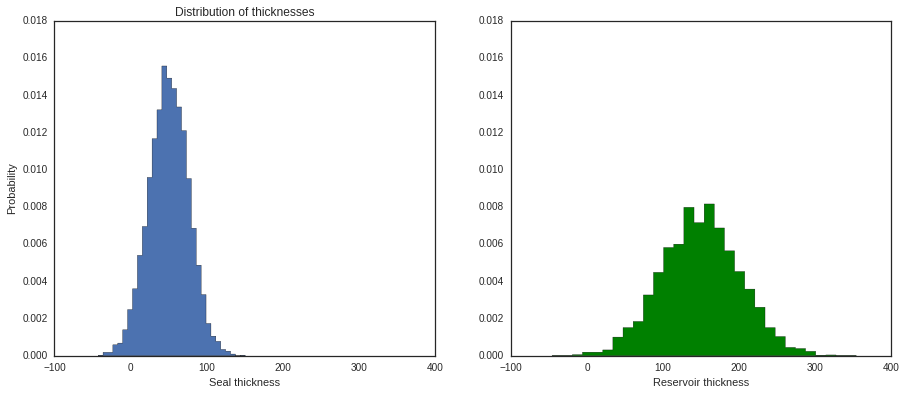

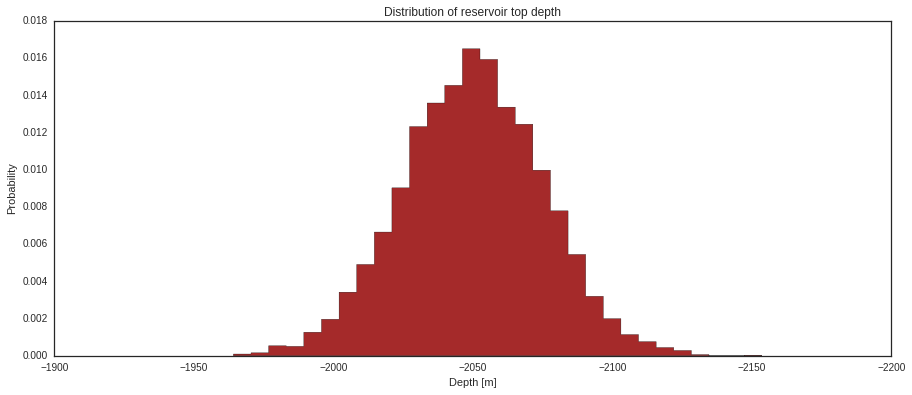

In [111]:
figsize(15,6)
fig, ax = plt.subplots(1, 2)

ax[0].hist(seal_thickness, histtype='stepfilled', bins=30, alpha=1,
    label="Seal", normed=True)
ax[1].hist(reservoir_thickness, histtype='stepfilled', bins=30, alpha=1,
    label="Reservoir", normed=True, color = "g")

ax[0].set_title(r"""Distribution of thicknesses""")
ax[0].set_ylabel("Probability")
ax[0].set_xlabel("Seal thickness")
ax[1].set_xlabel("Reservoir thickness")
ax[0].set_xlim([-100,400])
ax[1].set_xlim([-100,400])
ax[0].set_ylim([0,0.018])
ax[1].set_ylim([0,0.018])

fig, ax = plt.subplots(1, 1)
plt.hist(beta_samples_all, histtype='stepfilled', bins=30, alpha=1,
 label="Reservoir Depth", normed=True, color = "brown")

ax.set_title(r"""Distribution of reservoir top depth""")
ax.set_ylabel("Probability")
ax.set_xlabel("Depth [m]")
ax.set_xlim([-1900,-2200])
ax.set_ylim([0,0.018]);

- Figure 2: Probability distribution for the three uncertain model input parameters seal thickness, reservoir thickness and reservoir depth.

In [112]:
#MCMC with 2 inputs: reservoir thickness and depth
th_v = 20 #value per meter reservoir thickness
dp_c = 1  #cost per meter depth

res_top = pm.Normal("res_top", -2050, 1./np.square(25), value=-500)
res_bottom = pm.Normal("res_bottom", -2200, 1./np.square(45), value = 0)

@pm.deterministic
def res_thickness(res_top=res_top, res_bottom=res_bottom):
    return np.abs(res_top - res_bottom)

@pm.deterministic
def true_score(res_thickness=res_thickness, res_depth=res_top, th_v=th_v, dp_c=dp_c):
    return th_v * res_thickness + (dp_c * res_depth) 

model = pm.Model([true_score, res_thickness, res_top, res_bottom])

M = pm.MCMC(model)
M.sample(iter=5000)

 [-----------------100%-----------------] 5000 of 5000 complete in 0.6 sec

In [113]:
res_th_samples1 = M.trace("res_thickness")[:]
res_dp_samples1 = M.trace("res_top")[:]
res_bt_samples1 = M.trace("res_bottom")[:]
res_score_samples1 = M.trace("true_score")[:]

Portion of cases in which the score is negative: 0.1808
Mean of posterior distribution: 962.060005793
Median of posterior distribution: 969.943565525


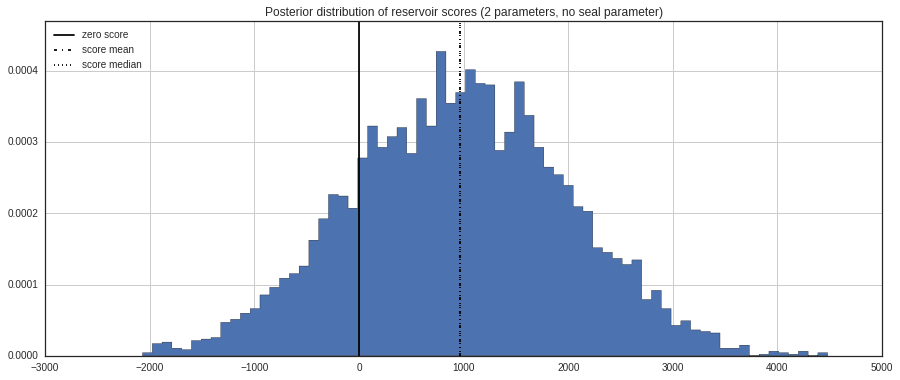

In [114]:
figsize(15, 6)

_hist = plt.hist(res_score_samples1, bins=70, normed=True, histtype="stepfilled")
plt.title("Posterior distribution of reservoir scores (2 parameters, no seal parameter)")
plt.vlines(0, 0, 1.1 * np.max(_hist[0]), label="zero score",
           linestyles="-")
plt.vlines(res_score_samples1.mean(), 0, 1.1 * np.max(_hist[0]),
           label="score mean", linestyles="-.")
plt.vlines(np.median(res_score_samples1), 0, 1.1 * np.max(_hist[0]),
           label="score median", linestyles=":")
plt.legend(loc="upper left");
plt.grid()
plt.ylim(0, 1.1 * np.max(_hist[0]))

negative_cases1 = (res_score_samples1<0).sum()/5000
print("Portion of cases in which the score is negative:",negative_cases1)
print("Mean of posterior distribution:",res_score_samples1.mean())
print("Median of posterior distribution:",np.median(res_score_samples1))

- Figure 3: Probability distribution for reservoir score using the two parameters reservoir thickness and reservoir depth.

### 3 parameter scoring

Influence by the seal thickness is added in the following. Score points are not added or substracted by this parameter directly. Instead, a threshold for seal reliability is defined beforehand. Here it is set at 20 m thickness. If the seal thickness falls below this threshold, it is assumed that the seal fails completely and thus all the potential value of the reservoir is lost, while costs of depth remain. 
Thus, a condition to check whether the seal is reliable is now included in the model. Results are visualized in Figure 4. The main distribution was not changed significantly, except for a striking peak of probability that emerged for the possibility of a score of -2000. Furthermore, mean and median have been shifted to lower values and are now found further apart.

In [115]:
seal_top = pm.Normal("seal_top", -2000, 1./np.square(7.))
seal_to = 20 #Minimum treshold for seal to be safe

@pm.deterministic
def score_if_seal(res_thickness=res_thickness, res_depth=res_top, \
                  th_v=th_v, dp_c=dp_c):
    return (th_v * res_thickness + (dp_c * res_depth))

@pm.deterministic
def true_score2(seal_top=seal_top, res_top=res_top,
                 dp_c=dp_c, res_depth=res_top, 
                 score_if_seal = score_if_seal):
    seal_th = seal_top - res_top
    if seal_th >= seal_to:
        x = score_if_seal
    else:
        x = (dp_c * res_depth)
    return x


model2 = pm.Model([true_score2, res_thickness, score_if_seal, res_top, res_bottom, seal_top])

M2 = pm.MCMC(model2)
M2.sample(iter=5000)

 [-----------------100%-----------------] 5000 of 5000 complete in 0.9 sec

In [116]:
M2.trace("true_score2")[:]
res_th_samples2 = M2.trace("res_thickness")[:]
seal_tp_samples2 = M2.trace("seal_top")[:]
res_tp_samples2 = M2.trace("res_top")[:]
res_dp_samples2 = M2.trace("res_top")[:]
res_bt_samples2 = M2.trace("res_bottom")[:]
res_score_samples2 = M2.trace("true_score2")[:]

Portion of cases in which the score is negative: 0.3038
Mean of posterior distribution: 463.295673339
Median of posterior distribution: 654.828817044


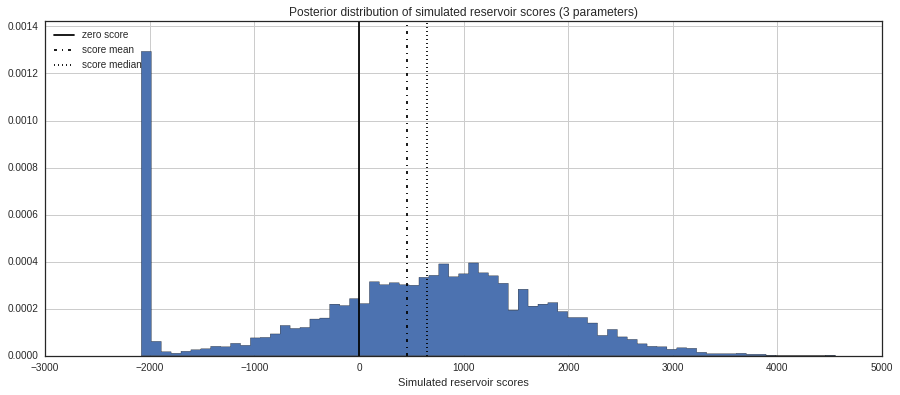

In [117]:
figsize(15, 6)

_hist = plt.hist(res_score_samples2, bins=70, normed=True, histtype="stepfilled")
plt.title("Posterior distribution of simulated reservoir scores (3 parameters)")
plt.vlines(0, 0, 1.1 * np.max(_hist[0]), label="zero score",
           linestyles="-")
plt.vlines(res_score_samples2.mean(), 0, 1.1 * np.max(_hist[0]),
           label="score mean", linestyles="-.")
plt.vlines(np.median(res_score_samples2), 0, 1.1 * np.max(_hist[0]),
           label="score median", linestyles=":")
plt.legend(loc="upper left");
plt.grid()
plt.ylim(0, 1.1 * np.max(_hist[0]))
plt.xlabel("Simulated reservoir scores")

negative_cases2 = (res_score_samples2<0).sum()/5000
print("Portion of cases in which the score is negative:",negative_cases2)
print("Mean of posterior distribution:",res_score_samples2.mean())
print("Median of posterior distribution:",np.median(res_score_samples2))

- Figure 4: Probability distribution for reservoir score using the three parameters reservoir thickness, reservoir depth and seal thickness.

### Designing the loss function

Now that a distribution of reservoir score probabilities has been modelled, a loss function for estimation of the true score value can be developed.

### Using standard loss functions

Some standard loss function were presented in chapter X (theory of loss fucntions to be explained in foregone chapter). For this case, the absolute-error loss and the squared-error loss function were considered as starting points, to design a more case-secipif loss function. Their general forms for certain determined values are illustrated in Figure 5.

Absolute-error loss function:

$$L( \theta, \hat{\theta} ) = ( \theta -  \hat{\theta} )$$

Squared-error loss function:

$$L( \theta, \hat{\theta} ) = ( \theta -  \hat{\theta} )^2$$

As explained before in chapter X, the expected loss for an estimate can be approximated by calculating the arithmetic mean of the losses compared to all samples in the modelled score distribution.

$$\frac{1}{N} \sum_{i=1}^N \;L(\theta_i, \hat{\theta} ) \approx E_{\theta}\left[ \; L(\theta, \hat{\theta}) \; \right]  = l(\hat{\theta} ) $$

Calculating the expected loss for estimates ranging from -3000 to 6000 using these two standard loss function results in the graphs depicted in Figure 6. As expected (find proper source!), the median of the distribution coincides with the minimum of the absolute-error and the median with the minimum of the squared-error expected loss (Bayes action/estimator).

In [118]:
res_score = res_score_samples2
estimates_g = np.arange(-5000,5000,50)

In [119]:
#I  - STANDARD LOSS FUNCTIONS
#Ia - Symmetric absolute loss function
def abs_loss(estimate_s, true_s):
        loss_s = np.zeros_like(true_s)
        underest = estimate_s < true_s
        overest = estimate_s > true_s
        loss_s[underest] = (true_s[underest] - estimate_s)
        loss_s[overest] = (estimate_s - true_s[overest])
        return loss_s
    
def abs_loss2(estimate_s, true_s):
        loss_s = np.zeros_like(true_s)
        for i in loss_s:
            loss_s[i] = abs(estimate_s - true_s[i])
        return loss_s

#Symmetric absolute loss for one given value
def simple_abs_loss(estimate_s, true_s):
        loss_s = abs(true_s - estimate_s)
        return loss_s
    
#Ib - Symmetric squared loss function
def sqr_loss(estimate_s, true_s):
        loss_s = np.zeros_like(true_s)
        underest = estimate_s < true_s
        overest = estimate_s > true_s
        loss_s[underest] = (true_s[underest] - estimate_s)**2
        loss_s[overest] = (estimate_s - true_s[overest])**2
        return loss_s
    
def sqr_loss2(estimate_s, true_s):
        loss_s = np.zeros_like(true_s)
        for i in loss_s:
            loss_s[i] = abs(estimate_s - true_s[i])**2
        return loss_s
    
#Symmetric squared loss for one given value
def simple_sqr_loss(estimate_s, true_s):
        loss_s = abs(true_s - estimate_s)**2
        return loss_s

In [120]:
given_score1=-750
given_score2=0
given_score3=750

expected_absloss_s1 = lambda estimate_s: simple_abs_loss(estimate_s, given_score1)
expected_absloss_s2 = lambda estimate_s: simple_abs_loss(estimate_s, given_score2)
expected_absloss_s3 = lambda estimate_s: simple_abs_loss(estimate_s, given_score3)

expected_sqrloss_s1 = lambda estimate_s: simple_sqr_loss(estimate_s, given_score1)
expected_sqrloss_s2 = lambda estimate_s: simple_sqr_loss(estimate_s, given_score2)
expected_sqrloss_s3 = lambda estimate_s: simple_sqr_loss(estimate_s, given_score3)

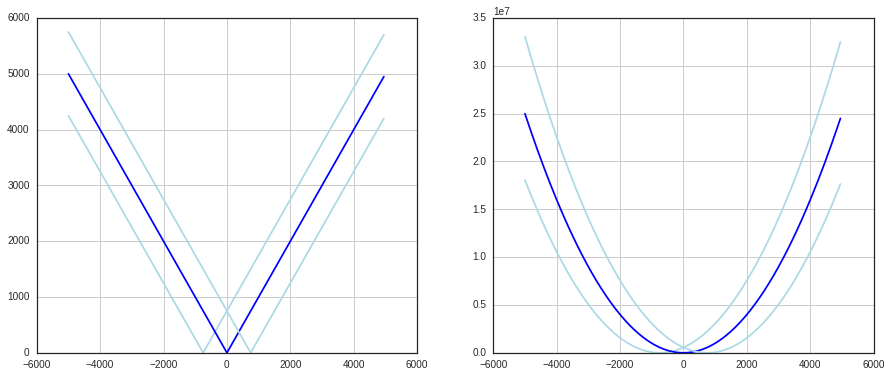

In [121]:
figsize(15, 6)
fig, ax = plt.subplots(1, 2)
ax[0].grid()
ax[1].grid()

#absolute
absloss = [expected_absloss_s1(e) for e in estimates_g]
ax[0].plot(estimates_g, absloss, color = 'lightblue')

absloss = [expected_absloss_s2(e) for e in estimates_g]
ax[0].plot(estimates_g, absloss, color = 'blue')

absloss = [expected_absloss_s3(e) for e in estimates_g]
ax[0].plot(estimates_g, absloss, color = 'lightblue')

#squared
sqrloss = [expected_sqrloss_s1(e) for e in estimates_g]
ax[1].plot(estimates_g, sqrloss, color = 'lightblue')

sqrloss = [expected_sqrloss_s2(e) for e in estimates_g]
ax[1].plot(estimates_g, sqrloss, color = 'blue')

sqrloss = [expected_sqrloss_s3(e) for e in estimates_g]
ax[1].plot(estimates_g, sqrloss, color = 'lightblue');

- Figure 5: Absolute-error and squared-error loss graphs for the given values -750, 0 and 750.

In [122]:
estimates_s = np.arange(-3000,6000,5)

Bayes action (min. expected loss) using absolute loss: 655.00
Bayes action (min. expected loss) using squared loss: 463.30


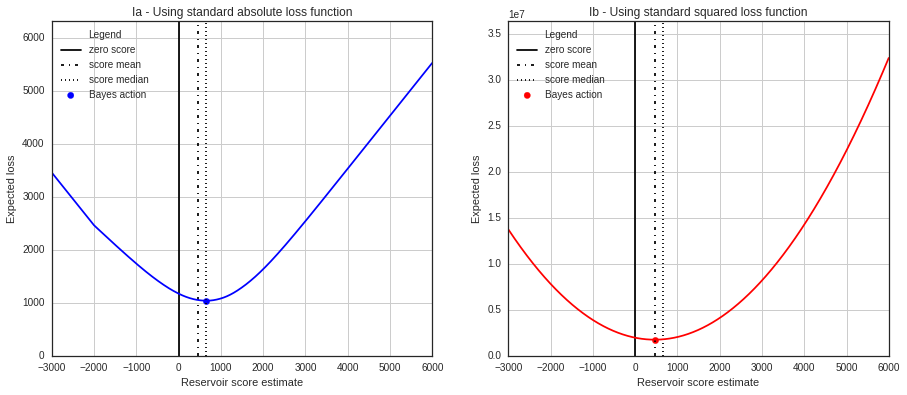

In [123]:
figsize(15, 6)
fig, ax = plt.subplots(1, 2)

ax[0].grid()
ax[0].vlines(0, 0, 1.1 * np.max(absloss), label="zero score", linestyles="-")
ax[0].vlines(res_score.mean(), 0, 1.1 * np.max(absloss), label="score mean", linestyles="-.")
ax[0].vlines(np.median(res_score_samples2), 0, 1.1 * np.max(absloss), label="score median", linestyles=":")
ax[0].set_xlabel("Reservoir score estimate")
ax[0].set_ylabel("Expected loss")
ax[0].set_title("Ia - Using standard absolute loss function")
ax[0].set_xlim(estimates_s[0], estimates_s[-1])
ax[0].set_ylim(0,1.1 * np.max(absloss))

ax[1].grid()
ax[1].vlines(0, 0, 1.1 * np.max(sqrloss), label="zero score", linestyles="-")
ax[1].vlines(res_score.mean(), 0, 1.1 * np.max(sqrloss), label="score mean", linestyles="-.")
ax[1].vlines(np.median(res_score_samples2), 0, 1.1 * np.max(sqrloss), label="score median", linestyles=":")
ax[1].set_xlabel("Reservoir score estimate")
ax[1].set_ylabel("Expected loss")
ax[1].set_title("Ib - Using standard squared loss function")
ax[1].set_xlim(estimates_s[0], estimates_s[-1])
ax[1].set_ylim(0,1.1 * np.max(sqrloss))

#Expected absolute loss
expected_abs_loss = lambda estimate_s: simple_abs_loss(estimate_s, res_score).mean()
absloss = [expected_abs_loss(e) for e in estimates_s]
ax[0].plot(estimates_s, absloss, color = 'blue')
_min_absloss = sop.fmin(expected_abs_loss, 40,disp = False)
ax[0].scatter(_min_absloss, np.min(absloss), s = 40, color = 'blue', label = "Bayes action")
print("Bayes action (min. expected loss) using absolute loss: %.2f" % (_min_absloss))

#Expected squared loss
expected_sqr_loss = lambda estimate_s: sqr_loss(estimate_s, res_score).mean()
sqrloss = [expected_sqr_loss(e) for e in estimates_s]
ax[1].plot(estimates_s, sqrloss, color = 'red')
_min_sqrloss = sop.fmin(expected_sqr_loss, 40,disp = False)
ax[1].scatter(_min_sqrloss, np.min(sqrloss), s = 40, color = 'red', label = "Bayes action")
print("Bayes action (min. expected loss) using squared loss: %.2f" % (_min_sqrloss))

ax[0].legend(loc="upper left", scatterpoints=1, title="Legend");
ax[1].legend(loc="upper left", scatterpoints=1, title="Legend");

- Figure 6: Expected loss based on the standard absolute-error loss (Ia, blue) and squared-loss function (Ib, red).

### Adaptions to develop a customized loss function

These standard loss functions provide objectively good estimators minimizing expected loss. Due to their symmetric properties, both will always give the median or mean of the underlying distribution as minimizing estimator respectively. However, assigning an economic notion to our model and assuming the case of an actor or decision maker in any field, naturally necessitates the consideration of preferences, interests and the overall subjective perspective such an individual or company might have. Further constraints and influences can also me specific to the field, industry or generally to the problem at hand. Consequently, the design of a more specific non-standard and possibly asymmetric loss function might be required, so that an adapted Bayesian estimator can be found. One that includes subjective aspects and difference in weighting of particular gains or losses, arising from an actors preferences and the environment in which the actor has to estimate or make a decision.
In the face of several uncertain parameters, a perfectly true estimate is virtually unattainable. However, the attempt can be made, to design a customized loss function that returns a Bayesian estimator involving the least bad consequences for an actor in a specific environment. Regarding the petroleum system case modelled above, such an attempt is made and explained step by step in the following. 

In [124]:
#Weight factors
ov = 1.25
ov_b = 2

In [125]:
#II - Variations of asymmetric absolute loss function

#IIa - Adaption: Underestimation and overestimation irrelevant if both negative (Introducing irrelevant cases)
def res_score_loss1(estimate_s, true_s):
        loss_s = np.zeros_like(true_s)
        underest = (estimate_s < true_s) & (estimate_s >= 0)
        overest = (estimate_s > true_s) & (estimate_s >= 0)
        loss_s[underest] = (true_s[underest] - estimate_s)
        loss_s[overest] = (estimate_s - true_s[overest])
        return loss_s
    
#IIb - Adaption: Overestimation worse than underestimation
def res_score_loss2(estimate_s, true_s):
        loss_s = np.zeros_like(true_s)
        underest = (estimate_s < true_s) & (estimate_s >= 0)
        overest = (estimate_s > true_s) & (estimate_s >= 0)
        loss_s[underest] = (true_s[underest] - estimate_s)
        loss_s[overest] = (estimate_s - true_s[overest])*ov
        return loss_s    
    
#IIc - Adaption: Introducing "worst" overestimation
def res_score_loss3(estimate_s, true_s):
        loss_s = np.zeros_like(true_s)
        underest = (estimate_s < true_s) & (estimate_s >= 0)
        overest = (estimate_s > true_s) & (estimate_s >= 0)
        overest_bad = (estimate_s > 0) & (true_s <= 0)
        loss_s[underest] = (true_s[underest] - estimate_s)
        loss_s[overest] = (estimate_s - true_s[overest])*ov
        loss_s[overest_bad] = (estimate_s - true_s[overest_bad])*ov_b
        return loss_s
    
#IId - Adaption: Introducing "worst" underestimation
def res_score_loss4(estimate_s, true_s):
        loss_s = np.zeros_like(true_s)
        underest = (estimate_s < true_s) & (estimate_s >= 0)
        underest_bad = (estimate_s <= 0) & (true_s > 0)
        overest = (estimate_s > true_s) & (estimate_s >= 0)
        overest_bad = (estimate_s > 0) & (true_s <= 0)
        loss_s[underest] = (true_s[underest] - estimate_s)
        loss_s[underest_bad] = true_s[underest_bad]
        loss_s[overest] = (estimate_s - true_s[overest])*ov
        loss_s[overest_bad] = (estimate_s - true_s[overest_bad])*ov_b
        return loss_s
    
#IId.2 - Version for given values
def res_score_lossG(estimate_s, true_s):
        if estimate_s < true_s:
            if estimate_s <= 0 and true_s > 0:
                loss_s = true_s #bad case of underestimation
            elif estimate_s < true_s and true_s <= 0: #"good"/irrelevant underestimation
                loss_s = 0
            else:
                loss_s = (true_s - estimate_s) #normal underestimation
        elif estimate_s > true_s:
            if estimate_s > 0 and true_s <= 0:
                loss_s = (estimate_s - true_s)*ov_b #bad case of overestimation
            elif estimate_s > true_s and estimate_s <= 0: #"good"/irrelevant overestimation
                loss_s = 0
            else:
                loss_s = (estimate_s - true_s)*ov #normal overestimation
        else:
            loss_s = 0
        return loss_s

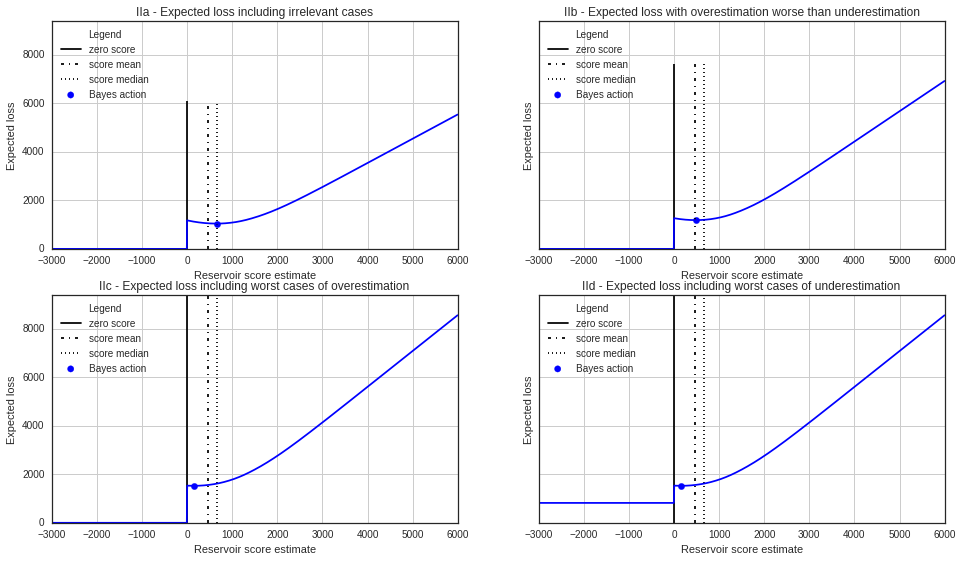

In [126]:
figsize(16, 9)
fig, ax = plt.subplots(2, 2, sharey=True)

#IIa
expected_loss_s = lambda estimate_s: res_score_loss1(estimate_s, res_score).mean()

loss = [expected_loss_s(e) for e in estimates_s]
_min_loss1 = sop.fmin(expected_loss_s, 40, disp = False)
ax[0,0].vlines(0, 0, 1.1 * np.max(loss), label="zero score", linestyles="-")
ax[0,0].vlines(res_score.mean(), 0, 1.1 * np.max(loss), label="score mean", linestyles="-.")
ax[0,0].vlines(np.median(res_score), 0, 1.1 * np.max(loss), label="score median", linestyles=":")
ax[0,0].plot(estimates_s, loss, color = 'blue')
ax[0,0].scatter(_min_loss1, expected_loss_s(_min_loss1), s = 40, color = 'blue', label = "Bayes action")
ax[0,0].set_title("""IIa - Expected loss including irrelevant cases""")    
ax[0,0].set_xlabel("Reservoir score estimate")
ax[0,0].set_ylabel("Expected loss")
ax[0,0].set_xlim(estimates_s[0], estimates_s[-1])
ax[0,0].set_ylim(0,1.1 * np.max(loss))
ax[0,0].grid()
ax[0,0].legend(loc="upper left", scatterpoints=1, title="Legend");

#IIb
expected_loss_s = lambda estimate_s: res_score_loss2(estimate_s, res_score).mean()

loss = [expected_loss_s(e) for e in estimates_s]
_min_loss2 = sop.fmin(expected_loss_s, 40, disp = False)
ax[0,1].vlines(0, 0, 1.1 * np.max(loss), label="zero score", linestyles="-")
ax[0,1].vlines(res_score.mean(), 0, 1.1 * np.max(loss), label="score mean", linestyles="-.")
ax[0,1].vlines(np.median(res_score), 0, 1.1 * np.max(loss), label="score median", linestyles=":")
ax[0,1].plot(estimates_s, loss, color = 'blue')
ax[0,1].scatter(_min_loss2, expected_loss_s(_min_loss2), s = 40, color = 'blue', label = "Bayes action")
ax[0,1].set_title("""IIb - Expected loss with overestimation worse than underestimation""")    
ax[0,1].set_xlabel("Reservoir score estimate")
ax[0,1].set_ylabel("Expected loss")
ax[0,1].set_xlim(estimates_s[0], estimates_s[-1])
ax[0,1].set_ylim(0,1.1 * np.max(loss))
ax[0,1].grid()
ax[0,1].legend(loc="upper left", scatterpoints=1, title="Legend");

#IIc
expected_loss_s = lambda estimate_s: res_score_loss3(estimate_s, res_score).mean()

loss = [expected_loss_s(e) for e in estimates_s]
_min_loss3 = sop.fmin(expected_loss_s, 40, disp = False)
ax[1,0].vlines(0, 0, 1.1 * np.max(loss), label="zero score", linestyles="-")
ax[1,0].vlines(res_score.mean(), 0, 1.1 * np.max(loss), label="score mean", linestyles="-.")
ax[1,0].vlines(np.median(res_score), 0, 1.1 * np.max(loss), label="score median", linestyles=":")
ax[1,0].plot(estimates_s, loss, color = 'blue')
ax[1,0].scatter(_min_loss3, expected_loss_s(_min_loss3), s = 40, color = 'blue', label = "Bayes action")
ax[1,0].set_title("""IIc - Expected loss including worst cases of overestimation""")    
ax[1,0].set_xlabel("Reservoir score estimate")
ax[1,0].set_ylabel("Expected loss")
ax[1,0].set_xlim(estimates_s[0], estimates_s[-1])
ax[1,0].set_ylim(0,1.1 * np.max(loss))
ax[1,0].grid()
ax[1,0].legend(loc="upper left", scatterpoints=1, title="Legend");

#IId
expected_loss_s = lambda estimate_s: res_score_loss4(estimate_s, res_score).mean()

loss = [expected_loss_s(e) for e in estimates_s]
_min_loss4 = sop.fmin(expected_loss_s, 40, disp = False)
ax[1,1].vlines(0, 0, 1.1 * np.max(loss), label="zero score", linestyles="-")
ax[1,1].vlines(res_score.mean(), 0, 1.1 * np.max(loss), label="score mean", linestyles="-.")
ax[1,1].vlines(np.median(res_score), 0, 1.1 * np.max(loss), label="score median", linestyles=":")
ax[1,1].plot(estimates_s, loss, color = 'blue')
ax[1,1].scatter(_min_loss4, expected_loss_s(_min_loss4), s = 40, color = 'blue', label = "Bayes action")
ax[1,1].set_title("""IId - Expected loss including worst cases of underestimation""")    
ax[1,1].set_xlabel("Reservoir score estimate")
ax[1,1].set_ylabel("Expected loss")
ax[1,1].set_xlim(estimates_s[0], estimates_s[-1])
ax[1,1].set_ylim(0,1.1 * np.max(loss))

ax[1,1].grid()
ax[1,1].legend(loc="upper left", scatterpoints=1, title="Legend");

- Figure 7: 

For the purpose of estimation, it makes sense that a standard loss function is chosen as a basis. The absolute-error loss seems most approriate for this case of petroleum reservoir value estimation. 
As stated above, the reservoir score we defined is an abstract and simplified way to reflect a value contained in the reservoir. An actor would wish to extract this, should it be positive (and feasible, but this would require the inclusion of numerous more factors). Ideally, an actor would like to know the exact true score, so that investments or resources can appropriately be allocated. This allocation is the decision to be made or action to be taken. Deviations from the unknown true score in the form of over- and underestimation bring about an error and loss accordingly. In principle, there is no reason for loss to increase exponentially with distance from the true value. Allocation of  investments would not increase exponentially with linear increase of the value of the resource. For this reason, the absolute-error loss function is favored over the squared-error loss function in this case.
Some adaptions are made below, based on mostly logical case-specific assumptions.

- 1st Adaption: For any negative estimate, an actor will take the same action as for a zero score, i.e. not to invest at all, since there is no positive value present. If the true score is zero or negative, this means that over- and underestimating, while the estimate is also negative or zero, is irrelevant an results in:

$$L( \theta, \hat{\theta} ) = 0$$

In other words: There is nothing to win and nothing is lost, since no action is taken.

- 2nd Adaption: Considering the development of a petroleum reservoir, one might also assume that overinvesting is worse than underinvesting. Overestimating the size of a reservoir might for example lead to the installation of equipment or facilites that are actually not needed. This comes with additional unrecoverable expenditures. Consequences from underestimating, however, may presumably be easier to resolve. Additional equipment can often be installed later afterwards. Hence, overestimation is weighted stronger in our loss function by multiplying the error with an overstimation factor a = 1.25:

$$L( \theta, \hat{\theta} ) = |( \theta -  \hat{\theta} )| * a$$

- 3d Adaption: The worst case for any project would be, to start and progress its development, only to discover later that the value in the reservoir does not cover the costs of realizing the project. A petroleum system might also turn out to be a complete failure, although the actor's estimate indicated the opposite. This is refered to here as a worst case or fatal overestimation, when a positive score is estimated, but the true score is zero or negative. It is included in the loss function with a second weighting factor b = 2:

$$L( \theta, \hat{\theta} ) = |( \theta -  \hat{\theta} )| * b$$

In other words: Worst case or fatal overestimation is twice as bad as simply underestimating.

- 4th Adaption: A worst case or fatal underestimation can also be derived from the idea of estimating a zero or negative score, when the true score is actually positive. This basically reflects the opportunity costs of completely discarding a reservoir with a true score of $\theta$:

$$L( \theta, \hat{\theta} ) = \theta$$

A step by step realization of these four adaptions is depicted in the plots in Figure 7. The first adaption is visualized in plot IIa, reflecting the irrelevance of negative estimates. Assignment of a stronger weight to overestimation, has led to a shift of the Bayesian action to a lower value in IIb. This shift has been in reinforced in plott IIc, due to adopting the concept of fatal overestimation. Finally, the inclusion of worst case underestimation raises the baseline for expected loss of not developing the reservoir (estimating zero or negative score).

The implementation of this customized loss function using single deterministed values for the true score is plotted in Figure 8.

It has to be emphasized that this is just one possible proposal for customization. There exists not one perfect loss function design for such a case. Other designs might differ slightly, for example by choosing different values for the same factors, to fundamentally by basing it on a significantly different mathematical structure.
Loss functions are customized according to the subjective needs and objectives of an actor. Thus, they are defined by the actor expressing his perspective and might change, should the actor change his mind. Especially considering individual persons as actors, even psychological aspects may play a significant role. 

(Estimate or prediction? True value only known if a "yes"-action (development) is taken.)

In [127]:
print("Portion of cases in which the score is negative:",negative_cases2)
print("Mean of posterior distribution: %d" % (res_score.mean()))  
print("Median of posterior distribution:",np.median(res_score))
print()
print("IIa - Bayes action (min. expected loss): %.2f; expected loss: %f" % (_min_loss1, expected_loss_s(_min_loss1)))
print("IIb - Bayes action (min. expected loss): %.2f; expected loss: %f" % (_min_loss2, expected_loss_s(_min_loss2)))
print("IIc - Bayes action (min. expected loss): %.2f; expected loss: %f" % (_min_loss3, expected_loss_s(_min_loss3)))
print("IId - Bayes action (min. expected loss): %.2f; expected loss: %f" % (_min_loss4, expected_loss_s(_min_loss4)))

Portion of cases in which the score is negative: 0.3038
Mean of posterior distribution: 463
Median of posterior distribution: 654.828817044

IIa - Bayes action (min. expected loss): 655.00; expected loss: 1611.224998
IIb - Bayes action (min. expected loss): 482.58; expected loss: 1561.484780
IIc - Bayes action (min. expected loss): 146.13; expected loss: 1523.492281
IId - Bayes action (min. expected loss): 146.13; expected loss: 1523.492281


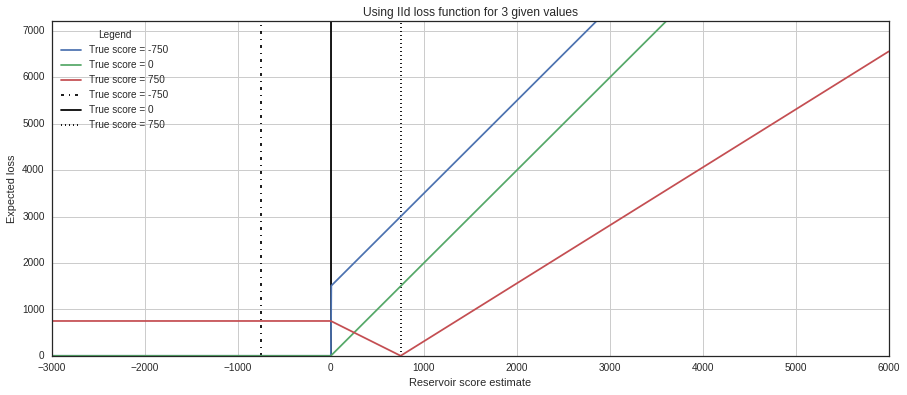

In [128]:
expected_loss_s1 = lambda estimate_s: res_score_lossG(estimate_s, given_score1)
expected_loss_s2 = lambda estimate_s: res_score_lossG(estimate_s, given_score2)
expected_loss_s3 = lambda estimate_s: res_score_lossG(estimate_s, given_score3)

figsize(15, 6)

loss = [expected_loss_s1(e) for e in estimates_s]
plt.plot(estimates_s, loss, label="True score = %d" % (given_score1))

loss = [expected_loss_s2(e) for e in estimates_s]
plt.plot(estimates_s, loss, label="True score = %d" % (given_score2))

loss = [expected_loss_s3(e) for e in estimates_s]
plt.plot(estimates_s, loss,label="True score = %d" % (given_score3))

plt.grid()
plt.vlines(given_score1, 0, 1.1 * np.max(loss), label="True score = %d" % (given_score1), linestyles="-.")
plt.vlines(given_score2, 0, 1.1 * np.max(loss), label="True score = %d" % (given_score2), linestyles="-")
plt.vlines(given_score3, 0, 1.1 * np.max(loss), label="True score = %d" % (given_score3), linestyles=":")
plt.xlabel("Reservoir score estimate")
plt.ylabel("Expected loss")
plt.title("Using IId loss function for 3 given values")
plt.xlim(estimates_s[0], estimates_s[-1])
plt.ylim(0,1.1 * np.max(loss));
plt.legend(loc="upper left", title="Legend");

- Figure 8: Realization of the customized loss function (IId) on three given deterministic true scores. 

### Including different risk affinities

One can assume that several actors in one sector or decision environment may have the same general loss functions, but different affinities concerning risks. This might be based on psychological factors or economic philosophies followed by a company. It might also be based on the budget and options such an actor has available. An intuitive example is the comparison of a small and a large company. A certain false estimate or error might have a significantly stronger impact on a company which has a a generally lower market share and only few projects, than on a larger company which might possess a higher financial flexibility and for which one project is only one of many development options. 

In the following, the loss function is further adapted to consider different risk-affinities of different actors. Representing risk behavior in a loss function can also be done in different ways. Here, it is simply included as a the factor r that is multiplied with the overestimation weighting factor a and b:

$$L( \theta, \hat{\theta} ) = |( \theta -  \hat{\theta} )| * (a * r)$$

$$L( \theta, \hat{\theta} ) = |( \theta -  \hat{\theta} )| * (b * r)$$

Thus, the risk-neutral loss function is returned for r = 1. For r < 1, the weight of overestimating is reduced. This represents a more risk-friendly actor that is willing to bid on a higher estimate to attain a higher return in value. For r > 1, the overestimation weight is increased and respectively more risk-averse actors are prompted to bid on lower estimates. They prefer a lower but safer return value, due to the higher loss of wrong overestimation.
The implementation of a risk-affinity factor r leads to different steepnesses of the plotted curves of the loss functions on the positive side of estimates (see Figures 9 and 10). The same three given deterministic values are used as true scores in the three plots in Figure 9. For certain determined values, the steepnesses of the functions vary, but their loss minima are found at the same location. However, in Figure 10 it can be seen that the minima for expected loss, i.e. the Bayesian estimators for differently risk-affine actors, are located at different estimates. Mean and median are clearly surpassed by the best estimate of the most risk-fiendly actor, while for the most risk-averse actor the Bayes action equals a zero estimate (and thus the decision to take on action).

In [129]:
#Risk parameters
risks_s = np.arange(0.5, 1.6, 0.25)
print(risks_s)

#Risk max loss
risks_s2 = np.arange(5000, 10000, 1000)
print(risks_s2)

[ 0.5   0.75  1.    1.25  1.5 ]
[5000 6000 7000 8000 9000]


In [130]:
#III - Introducing risk

#IIIa - Risk as a parameter influencing the weighting
def res_score_lossR(estimate_s, true_s, risk_s):
        loss_s = np.zeros_like(true_s)
        underest = (estimate_s < true_s) & (estimate_s >= 0)
        underest_bad = (estimate_s <= 0) & (true_s > 0)
        overest = (estimate_s > true_s) & (true_s >= 0)
        overest_bad = (estimate_s > 0) & (true_s <= 0)
        loss_s[underest] = (true_s[underest] - estimate_s)
        loss_s[underest_bad] = true_s[underest_bad]    #*(risk_s**(-2))
        loss_s[overest] = (estimate_s - true_s[overest])*(ov*risk_s)
        loss_s[overest_bad] = (estimate_s - true_s[overest_bad])*(ov_b*risk_s)
        return loss_s
    
def res_score_lossGR(estimate_s, true_s, risk_s):
        if estimate_s < true_s:
            if estimate_s <= 0 and true_s > 0:
                loss_s = true_s #bad case of underestimation
            elif estimate_s < true_s and true_s <= 0: #"good"/irrelevant underestimation
                loss_s = 0
            else:
                loss_s = (true_s - estimate_s) #normal underestimation
        elif estimate_s > true_s:
            if estimate_s > 0 and true_s <= 0:
                loss_s = (estimate_s - true_s)*(ov_b*risk_s) #bad case of overestimation
            elif estimate_s > true_s and estimate_s <= 0: #"good"/irrelevant overestimation
                loss_s = 0
            else:
                loss_s = (estimate_s - true_s)*(ov*risk_s) #normal overestimation
        else:
            loss_s = 0
        return loss_s
    
#IIIb - Risk as a max. loss
def res_score_lossR2(estimate_s, true_s, risk_s):
        loss_s = np.zeros_like(true_s)
        underest = (estimate_s < true_s) & (estimate_s >= 0)
        underest_bad = (estimate_s <= 0) & (true_s > 0)
        overest = (estimate_s > true_s) & (true_s >= 0)
        overest_bad = (estimate_s > 0) & (true_s <= 0)
        loss_s[underest] = (true_s[underest] - estimate_s)
        loss_s[underest_bad] = true_s[underest_bad]
        loss_s[overest] = (estimate_s - true_s[overest])*((ov*(risk_s/risks_s2[2])))
        loss_s[overest_bad] = risk_s
        return loss_s

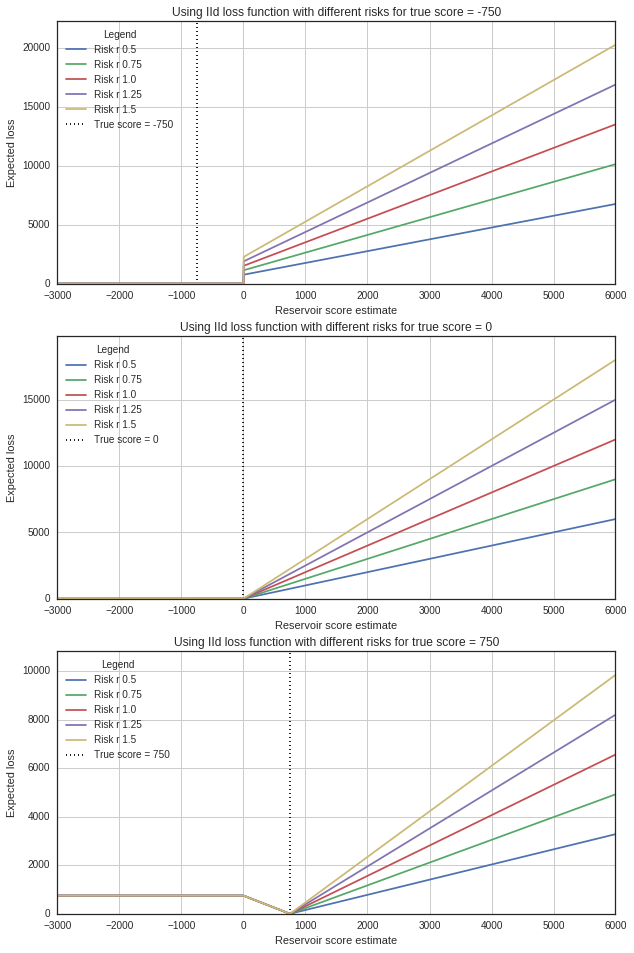

In [131]:
expected_loss_s1 = lambda estimate_s, risk_s: res_score_lossGR(estimate_s, given_score1, risk_s)
expected_loss_s2 = lambda estimate_s, risk_s: res_score_lossGR(estimate_s, given_score2, risk_s)
expected_loss_s3 = lambda estimate_s, risk_s: res_score_lossGR(estimate_s, given_score3, risk_s)
figsize(10, 16)
fig, ax = plt.subplots(3,1)

for r in risks_s:
    loss = [expected_loss_s1(e, r) for e in estimates_s]
    ax[0].plot(estimates_s, loss, label = "Risk r "+str(r))
ax[0].grid()
ax[0].vlines(given_score1, 0, 1.1 * np.max(loss), label="True score = %d" % (given_score1), linestyles=":")
ax[0].set_xlabel("Reservoir score estimate")
ax[0].set_ylabel("Expected loss")
ax[0].set_title("Using IId loss function with different risks for true score = %d" % (given_score1))
ax[0].set_xlim(estimates_s[0], estimates_s[-1])
ax[0].set_ylim(0,1.1 * np.max(loss));
ax[0].legend(loc="upper left", title="Legend");

for r in risks_s:
    loss = [expected_loss_s2(e, r) for e in estimates_s]
    ax[1].plot(estimates_s, loss, label = "Risk r "+str(r))
ax[1].grid()
ax[1].vlines(given_score2, 0, 1.1 * np.max(loss), label="True score = %d" % (given_score2), linestyles=":")
ax[1].set_xlabel("Reservoir score estimate")
ax[1].set_ylabel("Expected loss")
ax[1].set_title("Using IId loss function with different risks for true score = %d" % (given_score2))
ax[1].set_xlim(estimates_s[0], estimates_s[-1])
ax[1].set_ylim(0,1.1 * np.max(loss));
ax[1].legend(loc="upper left", title="Legend");

for r in risks_s:
    loss = [expected_loss_s3(e, r) for e in estimates_s]
    ax[2].plot(estimates_s, loss, label = "Risk r "+str(r))
ax[2].grid()
ax[2].vlines(given_score3, 0, 1.1 * np.max(loss), label="True score = %d" % (given_score3), linestyles=":")
ax[2].set_xlabel("Reservoir score estimate")
ax[2].set_ylabel("Expected loss")
ax[2].set_title("Using IId loss function with different risks for true score = %d" % (given_score3))
ax[2].set_xlim(estimates_s[0], estimates_s[-1])
ax[2].set_ylim(0,1.1 * np.max(loss));
ax[2].legend(loc="upper left", title="Legend");

- Figure 9:

Bayes action (minimum) at risk r 0.50: 784.67
Bayes action (minimum) at risk r 0.75: 423.59
Bayes action (minimum) at risk r 1.00: 146.13
Bayes action (minimum) at risk r 1.25: -4.00
Bayes action (minimum) at risk r 1.50: -4.00


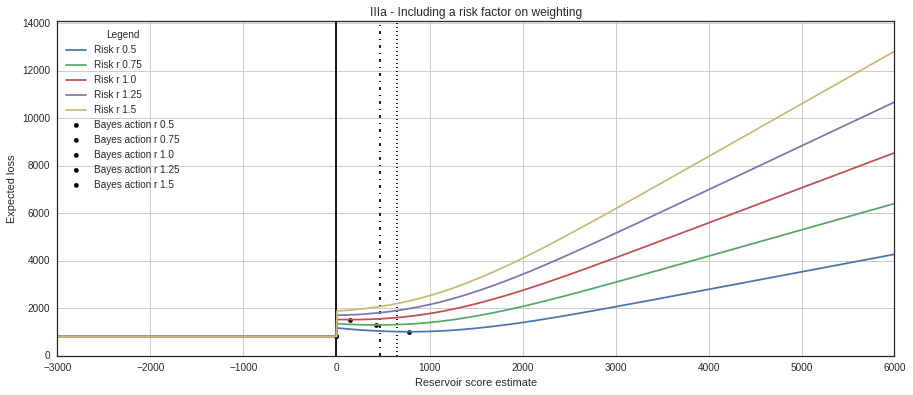

In [132]:
figsize(15, 6)
  
expected_loss_s = lambda estimate_s, risk_s: res_score_lossR(estimate_s, res_score, risk_s).mean()

for r in risks_s:
    loss = [expected_loss_s(e, r) for e in estimates_s]
    _min_score = sop.fmin(expected_loss_s, 40, args=(r,),disp = False)
    plt.plot(estimates_s, loss, label = "Risk r "+str(r))
    plt.scatter(_min_score, expected_loss_s(_min_score,r), s = 20, color = 'black', label = "Bayes action r "+str(r))
    #lt.vlines(_min_results, 0, 0.02, color = 'black', linestyles="--")
    print("Bayes action (minimum) at risk r %.2f: %.2f" % (r, _min_score))
    #print("Bayes action (minimum) at risk r %.2f: %.2f" % (r, expected_loss_s(0,r)))
    
plt.title("""IIIa - Including a risk factor on weighting""")    
plt.legend(loc="upper left", scatterpoints=1, title="Legend")
plt.vlines(0, 0, 1.1 * np.max(loss), label="zero score", linestyles="-")
plt.vlines(res_score.mean(), 0, 1.1 * np.max(loss), label="posterior's mean", linestyles="-.")
plt.vlines(np.median(res_score), 0, 1.1 * np.max(loss), label="score median", linestyles=":")
plt.xlabel("Reservoir score estimate")
plt.ylabel("Expected loss")
plt.xlim(estimates_s[0], estimates_s[-1])
plt.ylim(0,1.1 * np.max(loss))
plt.grid()

- Figure 10:

### Additional information in form of thickness likelihoods and reduced uncertainty

De la Varga (2016) made use of Bayesian inference to reduce the uncertainty in this type of one-dimensional model. The same is done here. The probability distributions for the location of the layer boundaries are treated as priors. Likelihood functions for the thicknesses of the layers are introduced as new information in the model. For the seal, a normal distribution with a mean of 25 m and a standard devation of 20 m is chosen to reflect the likelihood. For the reservoir, a normal distribution with a mean of 180 m and a standard deviation of 60 m is chosen. Implementing these likelihoods in the model, the uncertainty in the posterior probability distributions for the layer boundary depths is reduced (see Figure 11).

Modelling of a reservoir score is conducted as above, now based on these new distributions. In Figure 12 it can be recognized that the bulk of the distribution was shifted to the positive side and the peak at -2000 was raised. The probability of scores between -2000 and 0 decreased significantly. An interpretation of this would be that the true score is most likely either positive or -2000 if it is negative.

In [133]:
std1 = 15
std2 = 60

In [134]:
@pm.stochastic
def layer_thickness1(value = 0, alpha = seal_top, beta = res_top):
    a = alpha-beta
    return pm.normal_like(a, 40., 1./np.square(std1))

@pm.stochastic
def layer_thickness2(value = 0,  beta = res_top, gamma = res_bottom):
    b = beta-gamma
    return pm.normal_like(b, 180., 1./np.square(std2))

model3 = pm.Model([alpha, beta, gamma, layer_thickness1, layer_thickness2])

M3 = pm.MCMC(model3)
M3.sample(iter=10000, burn = 1000)

 [-----------------100%-----------------] 10000 of 10000 complete in 4.5 sec

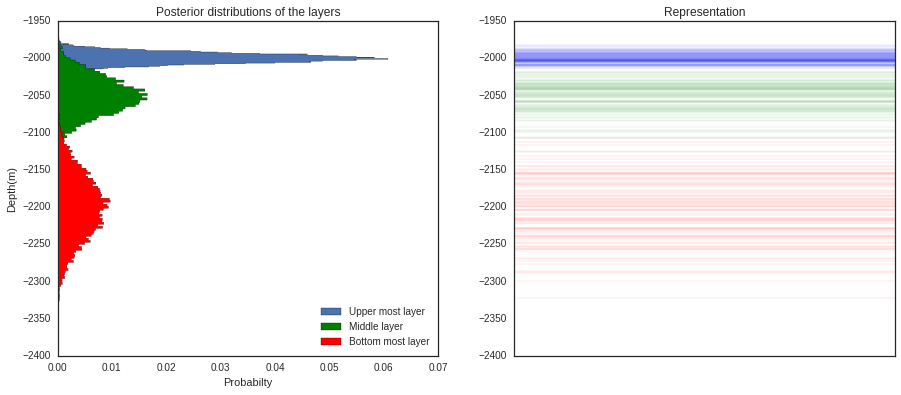

In [135]:
figsize(15,6)
fig, ax = plt.subplots(1, 2)
alpha_samples2 = M3.trace('alpha')[:]
beta_samples2 = M3.trace('beta')[:]
gamma_samples2 = M3.trace('gamma')[:]

alpha_samples2, alpha_samples_all2 = M3.trace('alpha')[-80:], M3.trace("alpha")[:]
beta_samples2, beta_samples_all2 = M3.trace('beta')[-80:], M3.trace("beta")[:]
gamma_samples2, gamma_samples_all2 = M3.trace('gamma')[-80:], M3.trace('gamma')[:]

#parameters = zip(alpha_samples2, beta_samples2, gamma_samples2)
#parameters_all = zip(alpha_samples_all2, beta_samples_all2, gamma_samples_all2)
ax[0].hist(alpha_samples_all2, histtype='stepfilled', bins=60, alpha=1,
    label="Upper most layer", normed=True,  orientation="horizontal")
ax[0].hist(beta_samples_all2, histtype='stepfilled', bins=60, alpha=1,
    label="Middle layer", normed=True, color = "g",  orientation="horizontal")
ax[0].hist(gamma_samples_all2, histtype='stepfilled', bins=120, alpha=1,
 label="Bottom most layer", normed=True, color = "r", orientation="horizontal")

ax[0].legend(loc = 0)
ax[0].set_title(r"""Posterior distributions of the layers""")
ax[0].set_ylabel("Depth(m)")
ax[0].set_xlabel("Probabilty")
ax[0].set_ylim([-2400,-1950])

ax[1].set_title("Representation")
ax[1].set_ylim([-2400,-1950])
ax[1].xaxis.set_visible(False)

for i in range(100):
    ax[1].axhline(alpha_samples_all2[-i], alpha = 0.05)
    ax[1].axhline(beta_samples_all2[-i], c = "g", alpha = 0.05)
    ax[1].axhline(gamma_samples_all2[-i],c = "r", alpha = 0.05)

- Figure 11:

In [136]:
@pm.deterministic
def score_if_seal_fail(res_depth=res_top, dp_c=dp_c):
    return (dp_c * res_depth)

@pm.deterministic
def true_score3(seal_top=seal_top, res_top=res_top,
                 dp_c=dp_c, res_depth=res_top, 
                 score_if_seal = score_if_seal, score_if_seal_fail=score_if_seal_fail):
    seal_th = seal_top - res_top
    seal_failure = seal_th < seal_to
    x = np.zeros_like(seal_top)
    x[~seal_failure] = score_if_seal[~seal_failure]
    x[seal_failure] = score_if_seal_fail[seal_failure]
    return x

model4 = pm.Model([true_score3, score_if_seal, score_if_seal_fail, layer_thickness1, layer_thickness2, res_top, res_bottom, seal_top])

M4= pm.MCMC(model4)
M4.sample(iter=10000, burn=1000)

 [-----------------100%-----------------] 10000 of 10000 complete in 4.6 sec

In [137]:
res_score2 = M4.trace("true_score3")[:]

Portion of cases in which the score is negative: 0.3038
Mean of posterior distribution: 1181.83702503
Median of posterior distribution: 1214.20143105


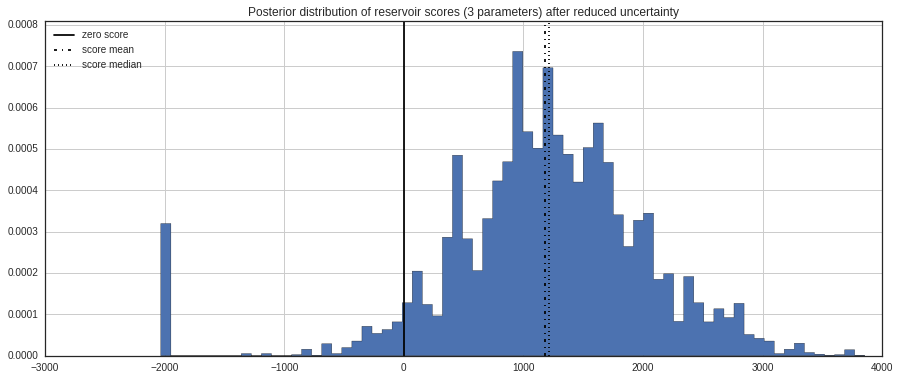

In [138]:
figsize(15, 6)

_hist = plt.hist(res_score2, bins=70, normed=True, histtype="stepfilled")
plt.title("Posterior distribution of reservoir scores (3 parameters) after reduced uncertainty")
plt.vlines(0, 0, 1.1 * np.max(_hist[0]), label="zero score", linestyles="-")
plt.vlines(res_score2.mean(), 0, 1.1 * np.max(_hist[0]), label="score mean", linestyles="-.")
plt.vlines(np.median(res_score2), 0, 1.1 * np.max(_hist[0]), label="score median", linestyles=":")
plt.legend(loc="upper left");
plt.grid()
plt.ylim(0, 1.1 * np.max(_hist[0]))

negative_cases3 = (res_score2<0).sum()/9000
print("Portion of cases in which the score is negative:",negative_cases2)
print("Mean of posterior distribution:",res_score2.mean())
print("Median of posterior distribution:",np.median(res_score2))

- Figure 12:

Bayes action (minimum) at risk r 0.50: 1397.93
Bayes action (minimum) at risk r 0.75: 1214.16
Bayes action (minimum) at risk r 1.00: 1082.29
Bayes action (minimum) at risk r 1.25: 989.61
Bayes action (minimum) at risk r 1.50: 927.62


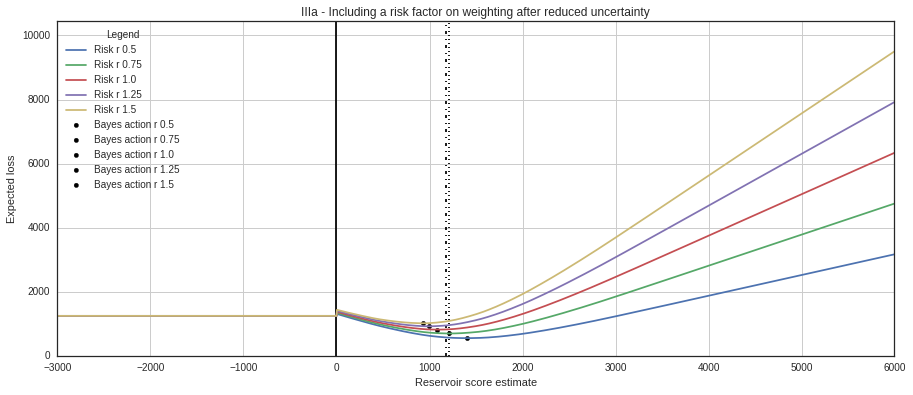

In [139]:
figsize(15, 6)
  
expected_loss_s= lambda estimate_s, risk_s: res_score_lossR(estimate_s, res_score2, risk_s).mean()

for r in risks_s:
    loss = [expected_loss_s(e, r) for e in estimates_s]
    _min_score = sop.fmin(expected_loss_s, 40, args=(r,),disp = False)
    plt.plot(estimates_s, loss, label = "Risk r "+str(r))
    plt.scatter(_min_score, expected_loss_s(_min_score,r), s = 20, color = 'black', label = "Bayes action r "+str(r))
    #lt.vlines(_min_results, 0, 0.02, color = 'black', linestyles="--")
    print("Bayes action (minimum) at risk r %.2f: %.2f" % (r, _min_score))
    
plt.title("""IIIa - Including a risk factor on weighting after reduced uncertainty""")    
plt.legend(loc="upper left", scatterpoints=1, title="Legend")
plt.vlines(0, 0, 1.1 * np.max(loss), label="zero score", linestyles="-")
plt.vlines(res_score2.mean(), 0, 1.1 * np.max(loss), label="posterior's mean", linestyles="-.")
plt.vlines(np.median(res_score2), 0, 1.1 * np.max(loss), label="score median", linestyles=":")
plt.xlabel("Reservoir score estimate")
plt.ylabel("Expected loss")
plt.xlim(estimates_s[0], estimates_s[-1])
plt.ylim(0,1.1 * np.max(loss))
plt.grid()

[ 784.66607666]
[ 423.58959961]
[ 146.13049316]
[-4.]
[-4.]


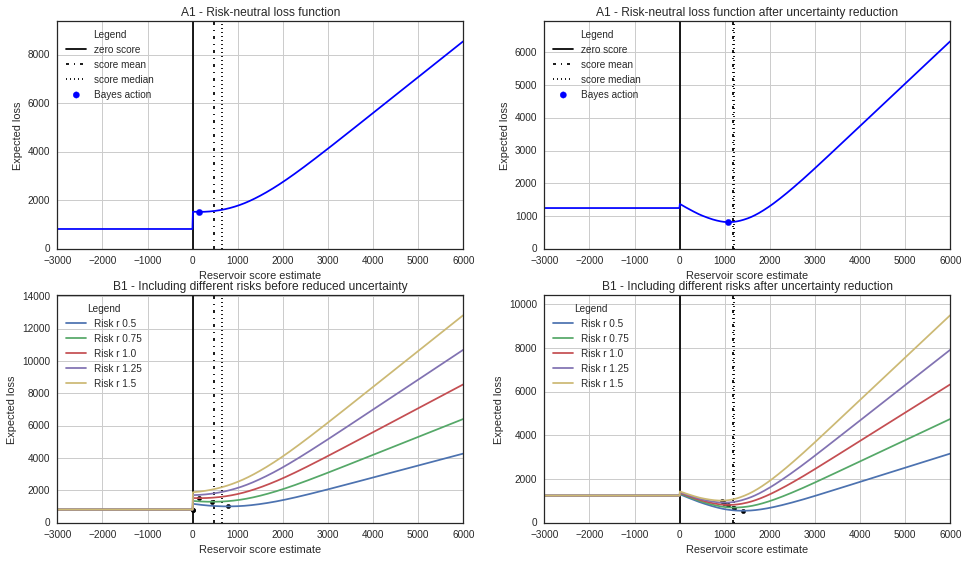

In [140]:
figsize(16, 9)
fig, ax = plt.subplots(2, 2)

# No reduced uncertainty, risk-neutral
expected_loss_s = lambda estimate_s: res_score_loss4(estimate_s, res_score).mean()

loss = [expected_loss_s(e) for e in estimates_s]
_min_loss4 = sop.fmin(expected_loss_s, 40, disp = False)
ax[0,0].vlines(0, 0, 1.1 * np.max(loss), label="zero score", linestyles="-")
ax[0,0].vlines(res_score.mean(), 0, 1.1 * np.max(loss), label="score mean", linestyles="-.")
ax[0,0].vlines(np.median(res_score), 0, 1.1 * np.max(loss), label="score median", linestyles=":")
ax[0,0].plot(estimates_s, loss, color = 'blue')
ax[0,0].scatter(_min_loss4, expected_loss_s(_min_loss4), s = 40, color = 'blue', label = "Bayes action")
ax[0,0].set_title("""A1 - Risk-neutral loss function""")    
ax[0,0].set_xlabel("Reservoir score estimate")
ax[0,0].set_ylabel("Expected loss")
ax[0,0].set_xlim(estimates_s[0], estimates_s[-1])
ax[0,0].set_ylim(0,1.1 * np.max(loss))
ax[0,0].grid()
ax[0,0].legend(loc="upper left", scatterpoints=1, title="Legend");

# Reduced uncertainty, risk-neutral
expected_loss_s = lambda estimate_s: res_score_loss4(estimate_s, res_score2).mean()

loss = [expected_loss_s(e) for e in estimates_s]
_min_loss4 = sop.fmin(expected_loss_s, 40, disp = False)
ax[0,1].vlines(0, 0, 1.1 * np.max(loss), label="zero score", linestyles="-")
ax[0,1].vlines(res_score2.mean(), 0, 1.1 * np.max(loss), label="score mean", linestyles="-.")
ax[0,1].vlines(np.median(res_score2), 0, 1.1 * np.max(loss), label="score median", linestyles=":")
ax[0,1].plot(estimates_s, loss, color = 'blue')
ax[0,1].scatter(_min_loss4, expected_loss_s(_min_loss4), s = 40, color = 'blue', label = "Bayes action")
ax[0,1].set_title("""A1 - Risk-neutral loss function after uncertainty reduction""")    
ax[0,1].set_xlabel("Reservoir score estimate")
ax[0,1].set_ylabel("Expected loss")
ax[0,1].set_xlim(estimates_s[0], estimates_s[-1])
ax[0,1].set_ylim(0,1.1 * np.max(loss))
ax[0,1].grid()
ax[0,1].legend(loc="upper left", scatterpoints=1, title="Legend");

# No reduced uncertainty, different risks
BA_before = np.zeros_like(risks_s)
EL_before = np.zeros_like(risks_s)
expected_loss_s = lambda estimate_s, risk_s: res_score_lossR(estimate_s, res_score, risk_s).mean()

counter = 0
for r in risks_s:
    loss = [expected_loss_s(e, r) for e in estimates_s]
    _min_score = sop.fmin(expected_loss_s, 40, args=(r,),disp = False)
    print(_min_score)
    if _min_score < 0:
        _min_score = 0
    ax[1,0].plot(estimates_s, loss, label = "Risk r "+str(r))
    ax[1,0].scatter(_min_score, expected_loss_s(_min_score,r), s = 20, color = 'black')
    #lt.vlines(_min_results, 0, 0.02, color = 'black', linestyles="--")
    #print("Bayes action (minimum) at risk r %.2f: %.2f" % (r, _min_score))
    BA_before[counter] = _min_score
    EL_before[counter] = expected_loss_s(_min_score,r)
    counter += 1
    
ax[1,0].set_title("""B1 - Including different risks before reduced uncertainty""")    
ax[1,0].legend(loc="upper left", scatterpoints=1, title="Legend")
ax[1,0].vlines(0, 0, 1.1 * np.max(loss), label="zero score", linestyles="-")
ax[1,0].vlines(res_score.mean(), 0, 1.1 * np.max(loss), label="posterior's mean", linestyles="-.")
ax[1,0].vlines(np.median(res_score), 0, 1.1 * np.max(loss), label="score median", linestyles=":")
ax[1,0].set_xlabel("Reservoir score estimate")
ax[1,0].set_ylabel("Expected loss")
ax[1,0].set_xlim(estimates_s[0], estimates_s[-1])
ax[1,0].set_ylim(0,1.1 * np.max(loss))
ax[1,0].grid()

# Reduced uncertainty, different risks
BA_after = np.zeros_like(risks_s)
EL_after = np.zeros_like(risks_s)
expected_loss_s= lambda estimate_s, risk_s: res_score_lossR(estimate_s, res_score2, risk_s).mean()

counter = 0
for r in risks_s:
    loss = [expected_loss_s(e, r) for e in estimates_s]
    _min_score = sop.fmin(expected_loss_s, 40, args=(r,),disp = False)
    if _min_score < 0:
        _min_score = 0
    ax[1,1].plot(estimates_s, loss, label = "Risk r "+str(r))
    ax[1,1].scatter(_min_score, expected_loss_s(_min_score,r), s = 20, color = 'black')
    #lt.vlines(_min_results, 0, 0.02, color = 'black', linestyles="--")
    #print("Bayes action (minimum) at risk r %.2f: %.2f" % (r, _min_score))
    BA_after[counter] = _min_score
    EL_after[counter] = expected_loss_s(_min_score,r)
    counter += 1
        
ax[1,1].set_title("""B1 - Including different risks after uncertainty reduction""")    
ax[1,1].legend(loc="upper left", scatterpoints=1, title="Legend")
ax[1,1].vlines(0, 0, 1.1 * np.max(loss), label="zero score", linestyles="-")
ax[1,1].vlines(res_score2.mean(), 0, 1.1 * np.max(loss), label="posterior's mean", linestyles="-.")
ax[1,1].vlines(np.median(res_score2), 0, 1.1 * np.max(loss), label="score median", linestyles=":")
ax[1,1].set_xlabel("Reservoir score estimate")
ax[1,1].set_ylabel("Expected loss")
ax[1,1].set_xlim(estimates_s[0], estimates_s[-1])
ax[1,1].set_ylim(0,1.1 * np.max(loss))
ax[1,1].grid()

- Figure 13: 

The customized loss function is now applied on this updated distribution of the reservoir score. This is visualized in Figure 13 in which the expected losses are compared before and after undertainty reduction. The risk-neutral loss function is depicted in plots A1 and A2, while in plots B1 and B2 different risk-affinities are included. It is observable, that after adding information about layer thickness likelihoods, Bayesian estimators shift relative to the nature of the information. In this case, the added data generally reinforces the likelihoods of the reservoir to be significantly thick and for the seal to be appropriately reliable. Thus, the minima of expected loss are found at higher estimates for all actors. 

#### Quantifying the value of added information and uncertainty reduction

This shift in Bayesian estimator can be quantified and shows in this case, that the risk-neutral actor experienced the greatest shift and actors most different in risk-affinity were were influenced the least, but still significantly.

In [141]:
print(BA_before)
print(BA_after)
BA_diff = BA_after - BA_before
print(BA_diff)
print()
print(EL_before)
print(EL_after)
EL_diff = EL_after - EL_before
print(EL_diff)

[ 784.66607666  423.58959961  146.13049316    0.            0.        ]
[ 1397.93292236  1214.16442871  1082.29473877   989.61132812   927.6204834 ]
[ 613.2668457   790.5748291   936.16424561  989.61132812  927.6204834 ]

[ 1012.96908478  1299.02620079  1523.49228134   819.01066047   819.01066047]
[  551.79406586   696.60764076   817.86813236   920.68023798  1015.65511223]
[-461.17501893 -602.41856003 -705.62414898  101.66957751  196.64445177]


Observation: Minimum of expected loss increased for all actors and more for those with low risk affinity (more risk-averse). At the same time, Bayes action shifted to the positive side for all actors, implying a higher estimate. This shift was greater for actors with lower risk affinity (more risk-averse).

In [142]:
counter = 0
for r in risks_s:
    print("Bayes action shift due to uncertainty reduction for r %.2f: %.2f -- \
    Shift in expected loss = %.2f" % (r, BA_diff[counter], EL_diff[counter]))
    counter += 1

Bayes action shift due to uncertainty reduction for r 0.50: 613.27 --     Shift in expected loss = -461.18
Bayes action shift due to uncertainty reduction for r 0.75: 790.57 --     Shift in expected loss = -602.42
Bayes action shift due to uncertainty reduction for r 1.00: 936.16 --     Shift in expected loss = -705.62
Bayes action shift due to uncertainty reduction for r 1.25: 989.61 --     Shift in expected loss = 101.67
Bayes action shift due to uncertainty reduction for r 1.50: 927.62 --     Shift in expected loss = 196.64


Bayes action (minimum) at risk r 5000.00: 1130.52
Bayes action (minimum) at risk r 6000.00: 1053.44
Bayes action (minimum) at risk r 7000.00: 981.65
Bayes action (minimum) at risk r 8000.00: 910.37
Bayes action (minimum) at risk r 9000.00: 848.10


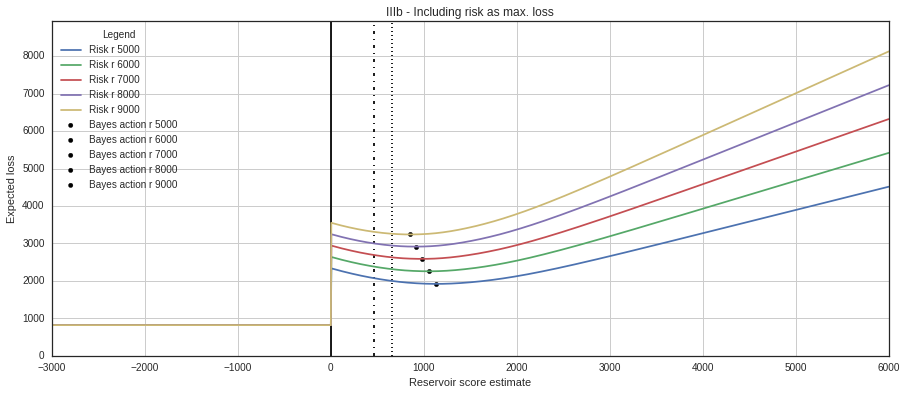

In [143]:
### Unused extra

figsize(15, 6)
  
expected_loss_s = lambda estimate_s, risk_s: res_score_lossR2(estimate_s, res_score, risk_s).mean()

for r in risks_s2:
    loss = [expected_loss_s(e, r) for e in estimates_s]
    _min_score = sop.fmin(expected_loss_s, 40, args=(r,),disp = False)
    plt.plot(estimates_s, loss, label = "Risk r "+str(r))
    plt.scatter(_min_score, expected_loss_s(_min_score,r), s = 20, color = 'black', label = "Bayes action r "+str(r))
    #lt.vlines(_min_results, 0, 0.02, color = 'black', linestyles="--")
    print("Bayes action (minimum) at risk r %.2f: %.2f" % (r, _min_score))
    
plt.title("""IIIb - Including risk as max. loss""")    
plt.legend(loc="upper left", scatterpoints=1, title="Legend")
plt.vlines(0, 0, 1.1 * np.max(loss), label="zero score", linestyles="-")
plt.vlines(res_score.mean(), 0, 1.1 * np.max(loss), label="posterior's mean", linestyles="-.")
plt.vlines(np.median(res_score), 0, 1.1 * np.max(loss), label="score median", linestyles=":")
plt.xlabel("Reservoir score estimate")
plt.ylabel("Expected loss")
plt.xlim(estimates_s[0], estimates_s[-1])
plt.ylim(0,1.1 * np.max(loss))
plt.grid()

### Alternative: Utility function???

In [144]:
def res_score_uR(estimate_s, true_s, risk_s):
        u = np.zeros_like(true_s)
        underest = (estimate_s < true_s) #& (estimate_s >= 0)
        underest_bad = (estimate_s <= 0) & (true_s > 0)
        overest = (estimate_s > true_s) #& (true_s >= 0)
        overest_bad = (estimate_s > 0) & (true_s <= 0)
        u[underest] = estimate_s - (true_s[underest] - estimate_s)
        u[underest_bad] = estimate_s - true_s[underest_bad]    #*(risk_s**(-2))
        u[overest] = estimate_s - (estimate_s - true_s[overest])*(ov*risk_s)
        u[overest_bad] = estimate_s - (estimate_s - true_s[overest_bad])*(ov_b*risk_s)
        return u
    
def res_score_uR(estimate_s, true_s, risk_s):
        u = np.ones_like(true_s)
        u = u * true_s
        underest = (estimate_s < true_s) #& (estimate_s >= 0)
        underest_bad = (estimate_s <= 0) & (true_s > 0)
        overest = (estimate_s > true_s) #& (true_s >= 0)
        overest_bad = (estimate_s > 0) & (true_s <= 0)
        u[underest] = estimate_s - (true_s[underest] - estimate_s)
        u[underest_bad] = estimate_s - true_s[underest_bad]    #*(risk_s**(-2))
        u[overest] = estimate_s - (estimate_s - true_s[overest])#*(ov*risk_s)
        u[overest_bad] = estimate_s - (estimate_s - true_s[overest_bad])#*(ov_b*risk_s)
        return u

Bayes action (minimum) at risk r 0.50: 848.10
Bayes action (minimum) at risk r 0.75: 848.10
Bayes action (minimum) at risk r 1.00: 848.10
Bayes action (minimum) at risk r 1.25: 848.10
Bayes action (minimum) at risk r 1.50: 848.10


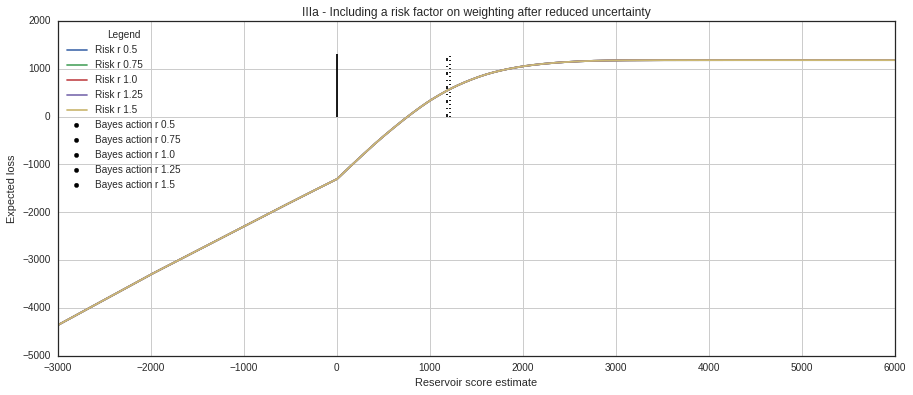

In [145]:
figsize(15, 6)
  
expected_loss_s= lambda estimate_s, risk_s: res_score_uR(estimate_s, res_score2, risk_s).mean()

for r in risks_s:
    loss = [expected_loss_s(e, r) for e in estimates_s]
    _max_score = sop.fmin(expected_loss_s, 40, args=(r,),disp = False)
    plt.plot(estimates_s, loss, label = "Risk r "+str(r))
    plt.scatter(_max_score, expected_loss_s(_min_score,r), s = 20, color = 'black', label = "Bayes action r "+str(r))
    #lt.vlines(_min_results, 0, 0.02, color = 'black', linestyles="--")
    print("Bayes action (minimum) at risk r %.2f: %.2f" % (r, _min_score))
    
plt.title("""IIIa - Including a risk factor on weighting after reduced uncertainty""")    
plt.legend(loc="upper left", scatterpoints=1, title="Legend")
plt.vlines(0, 0, 1.1 * np.max(loss), label="zero score", linestyles="-")
plt.vlines(res_score2.mean(), 0, 1.1 * np.max(loss), label="posterior's mean", linestyles="-.")
plt.vlines(np.median(res_score2), 0, 1.1 * np.max(loss), label="score median", linestyles=":")
plt.xlabel("Reservoir score estimate")
plt.ylabel("Expected loss")
plt.xlim(estimates_s[0], estimates_s[-1])
#plt.ylim(np.min(loss),1.1 * np.max(loss))
plt.grid()